# Classification model (XGBoost)

The problem of identifying underperforming students is approached from a binary classification point-of-view. We used the percentiles, that are related with the total score. This variable is our target for the classifier. We binarized the Percentiles creating the High_score target variable:
* Percentiles Above 50% -> High_score = True (Students getting a high score)
* Percentiles Below 50% -> High_score = False (Students getting a low score)

The High_score variable will be used to model the classifier that will detect low-score students.

In [1]:
#!pip install missingno
#!pip install category-encoders

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.formula.api as smf #Working on Docker
#import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
import missingno as msno
from src import funcs
#from statsmodels.formula.api import ols

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, MaxAbsScaler, OneHotEncoder
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression
#from category_encoders import OneHotEncoder

from sklearn import metrics
from sklearn.calibration import calibration_curve

import shap

import warnings
warnings.filterwarnings('ignore')

/home/wilomaku/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
from sklearn.utils.fixes import signature
import itertools

def plot_roc_pr_curve(X,y,modelo,flag):

    if flag == True:
        probs = modelo.predict_proba(X)
        preds = probs
    else:
        probs = modelo.predict_proba(X)
        preds = probs[:,1]

    fpr, tpr, threshold = metrics.roc_curve(y, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic Val')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    print('------------------------------------')
    print('ROC Curve Test:')
    plt.show()

    precision, recall, treshold = metrics.precision_recall_curve(y, preds)
    average_precision = metrics.average_precision_score(y, preds)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    plt.show()
    return precision, recall, treshold

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 fontsize=15,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()
    
def extract_normalization(pipeline,df,list_types):
    df_normal = pd.DataFrame([],columns=df.columns)
    df_normal.loc[0] = np.nan
    df_normal.loc[1] = np.nan
    df_normal['index'] = ['std','mean']
    df_normal.set_index('index',inplace=True)
    
    dict_header = {}
    for col_type in list_types:
        try:
            list_cols = pipeline.steps[1][1].steps[0][1].get_params()['{}__dumm_pl__columns'.format(col_type)]
            dict_header[col_type] = list_cols
        except:
            list_cols = pipeline.steps[1][1].steps[0][1].get_params()['{}__{}_pl__columns'.format(col_type,col_type)]
            dict_header[col_type] = list_cols
            
    list_normal = []
    for col_type in list_types:
        list_var = pipeline.steps[1][1].steps[0][1].get_params()['{}__scaler'.format(col_type)].var_
        list_mean = pipeline.steps[1][1].steps[0][1].get_params()['{}__scaler'.format(col_type)].mean_
        list_normal.extend(list(zip(list_var,list_mean)))
    
    i=0
    for col_type in list_types:
        for col in dict_header[col_type]:
            col_cols = [col_df for col_df in list(df.columns) if col in col_df]
            for col_col in col_cols:
                df_normal.loc['std',col_col] = np.sqrt(list_normal[i][0])
                df_normal.loc['mean',col_col] = list_normal[i][1]
                i += 1
                
    return df_normal

## Dataset loading

In [3]:
from xgboost import DMatrix
from xgboost import XGBClassifier
import xgboost
from skopt import gp_minimize

def objective(param):

    params = {'learning_rate': param[0],
        'max_depth': param[1],
        'reg_lambda': param[2],
        'gamma': param[3],
        'min_child_weight': param[4],
        'scale_pos_weight': param[5],
        'n_estimators':param[6]
       }

    cv_result = xgboost.cv(params = params, dtrain = dmatrix, nfold=5, metrics = 'auc')

    return 1 - cv_result['test-auc-mean'].values[-1]

def xgb_pipe(X, y, seed=1, test_size=0.2, minimize=None):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    xg = XGBClassifier(learning_rate=minimize.x[0], max_depth=minimize.x[1], reg_lambda=minimize.x[2],
                       gamma=minimize.x[3], min_child_weight=minimize.x[4],
                       scale_pos_weight=minimize.x[5], n_estimators=minimize.x[6])
    #xg = XGBClassifier(learning_rate=1, max_depth=6, reg_lambda=0, gamma=1, min_child_weight=3,
    #                   scale_pos_weight=1, n_estimators=957)

    pipe = Pipeline([('xg', xg),])

    pipe.fit(X_train,y_train)
    probs_test = pipe.predict_proba(X_test)
    preds = probs_test[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic Val')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    print('------------------------------------')
    print('ROC Curve Teste:')
    plt.show()

    print('Real Probability')
    plt.figure(figsize=(9, 9))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(pipe, 'xg')]:

        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=15)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

        ax2.hist(prob_pos, range=(0, 1), bins=30, label=name,
             histtype="step", lw=2)

        ax1.set_ylabel("Fraction of positives")
        ax1.set_ylim([-0.05, 1.05])
        ax1.legend(loc="lower right")
        ax1.set_title('Calibration plots  (reliability curve)')

        ax2.set_xlabel("Mean predicted value")
        ax2.set_ylabel("Count")
        ax2.legend(loc="upper center", ncol=2)

        plt.tight_layout()
    plt.show()

    return pipe

In [4]:
class ColumnExtractor(BaseEstimator, TransformerMixin):

    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

def create_feat(df):

    #Nacionalidad
    filter_nac = (df['ESTU_NACIONALIDAD']!='COLOMBIA')&(df['ESTU_NACIONALIDAD'].notnull())
    df.loc[filter_nac,'ESTU_NACIONALIDAD'] = 0

    filter_nac = df['ESTU_NACIONALIDAD']=='COLOMBIA'
    df.loc[filter_nac,'ESTU_NACIONALIDAD'] = 1

    #df['ESTU_NACIONALIDAD'] = df['ESTU_NACIONALIDAD'].astype('bool')

    #Método programa
    filter_nac = (df['ESTU_METODO_PRGM'] == 'DISTANCIA') | (df['ESTU_METODO_PRGM'] == 'SEMI-PRESENCIAL')
    df.loc[filter_nac,'ESTU_METODO_PRGM'] = 'DISTANCIA/SEMI-PRESENCIAL'

    filter_nac = df['ESTU_METODO_PRGM'] == 'DISTANCIA VITUAL'
    df.loc[filter_nac,'ESTU_METODO_PRGM'] = 'DISTANCIA VIRTUAL'

    #Carácter académico
    filter_nac = (df['INST_CARACTER_ACADEMICO']=='INSTITUCIÓN TECNOLÓGICA') |\
                 (df['INST_CARACTER_ACADEMICO']=='INSTITUCIÓN UNIVERSITARIA')
    df.loc[filter_nac,'INST_CARACTER_ACADEMICO'] = 'TECNOLÓGICA/UNIVERSITARIA'
    
    #Institución educativa
    l_inst = ['CORPORACION UNIVERSITARIA MINUTO DE DIOS','POLITECNICO GRANCOLOMBIANO',
              'UNIVERSIDAD COOPERATIVA DE COLOMBIA','UNIVERSIDAD NACIONAL ABIERTA Y A DISTANCIA UNAD',
              'UNIVERSIDAD NACIONAL DE COLOMBIA','FUNDACION UNIVERSITARIA DEL AREA ANDINA','UNIVERSIDAD LIBRE',
              'UNIVERSIDAD DE ANTIOQUIA','UNIVERSIDAD SANTO TOMAS','PONTIFICIA UNIVERSIDAD JAVERIANA',
              'CORPORACION UNIFICADA NACIONAL DE EDUCACION SUPERIOR','UNIVERSIDAD DEL TOLIMA',
              'CORPORACION UNIVERSITARIA REMINGTON','UNIVERSIDAD PONTIFICIA BOLIVARIANA',
              'UNIVERSIDAD PEDAGOGICA Y TECNOLOGICA DE COLOMBIA','UNIVERSIDAD DEL ATLANTICO',
              'UNIVERSIDAD DE PAMPLONA','UNIVERSIDAD DEL QUINDIO','UNIVERSIDAD FRANCISCO DE PAULA SANTANDER',
              'UNIVERSIDAD DE LOS ANDES','UNIVERSIDAD DEL VALLE','UNIVERSIDAD ANTONIO NARIÑO',
              'UNIVERSIDAD DE CARTAGENA','UNIVERSIDAD DE SAN BUENAVENTURA',
              'CORPORACION UNIVERSITARIA IBEROAMERICANA','UNIVERSIDAD SIMON BOLIVAR',
              'UNIVERSIDAD INDUSTRIAL DE SANTANDER','UNIVERSIDAD DE LA SALLE','UNIVERSIDAD LA GRAN COLOMBIA',
              'UNIVERSIDAD DEL MAGDALENA','UNIVERSIDAD SANTIAGO DE CALI',
              'UNIVERSIDAD DISTRITALFRANCISCO JOSE DE CALDAS','CORPORACION UNIVERSITARIA DEL CARIBE',
              'UNIVERSIDAD ECCI','UNIVERSIDAD MILITARNUEVA GRANADA','FUNDACION UNIVERSITARIA LUIS AMIGO FUNLAM',
              'UNIVERSIDAD DE CORDOBA','FUNDACION UNIVERSITARIA LOS LIBERTADORES','UNIVERSIDAD DEL NORTE',
              'UNIVERSIDAD DE CUNDINAMARCA','UNIVERSIDAD TECNOLOGICA DE PEREIRA','UNIVERSIDAD POPULAR DEL CESAR',
              'UNIVERSIDAD DEL CAUCA','FUNDACION UNIVERSIDAD DE BOGOTAJORGE TADEO LOZANO',
              'CORPORACION UNIVERSIDAD DE LA COSTA, CUC','ESCUELA SUPERIOR DE ADMINISTRACION PUBLICA',
              'UNIVERSIDAD EL BOSQUE','UNIVERSIDAD DE LA GUAJIRA','UNIVERSIDAD AUTONOMA DEL CARIBE',
              'UNIVERSIDAD CATOLICA DE COLOMBIA','UNIVERSIDAD EAFIT','UNIVERSIDAD DE MEDELLIN',
              'COLEGIO MAYOR DE NUESTRA SEÑORA DEL ROSARIO','FUNDACION UNIVERSITARIA SAN MARTIN',
              'UNIVERSIDAD SURCOLOMBIANA','UNIVERSIDAD DE CALDAS','UNIVERSIDAD CENTRAL','UNIVERSIDAD DE LA SABANA',
              'UNIVERSIDAD DEL SINÚ Elías Bechara Zainúm','UNIVERSIDAD SERGIO ARBOLEDA','UNIVERSIDAD DE SANTANDER',
              'UNIVERSIDAD AUTONOMA DE OCCIDENTE','CORPORACION UNIVERSITARIA AMERICANA']
    
    df['INST_NOMBRE_INSTITUCION'] = df['INST_NOMBRE_INSTITUCION'].apply(lambda x: x.replace('"',''))
    df['INST_NOMBRE_INSTITUCION'] = df['INST_NOMBRE_INSTITUCION'].apply(lambda x: x.replace("'",''))
    df['INST_NOMBRE_INSTITUCION'] = df['INST_NOMBRE_INSTITUCION'].apply(lambda x: x.split('-')[0].strip())
    df.loc[~df['INST_NOMBRE_INSTITUCION'].isin(l_inst),'INST_NOMBRE_INSTITUCION'] = 'new'

    #Lectura
    filter_nac = (df['ESTU_DEDICACIONLECTURADIARIA']=='No leo por entretenimiento')
    df.loc[filter_nac,'ESTU_DEDICACIONLECTURADIARIA'] = '30 minutos o menos'

    filter_nac = (df['ESTU_DEDICACIONLECTURADIARIA']=='Entre 1 y 2 horas') |\
                 (df['ESTU_DEDICACIONLECTURADIARIA']=='Entre 30 y 60 minutos')
    df.loc[filter_nac,'ESTU_DEDICACIONLECTURADIARIA'] = 'Entre 30 mins y 2 horas'

    df['ESTU_DEDICACIONLECTURADIARIA'] = pd.Categorical(df['ESTU_DEDICACIONLECTURADIARIA'],ordered=True,
                    categories=['30 minutos o menos','Entre 30 mins y 2 horas','Más de 2 horas'])

    #Internet
    filter_nac = (df['ESTU_DEDICACIONINTERNET']=='Entre 1 y 3 horas') |\
                 (df['ESTU_DEDICACIONINTERNET']=='Más de 4 horas')
    df.loc[filter_nac,'ESTU_DEDICACIONINTERNET'] = 'Mas de 1 hora'

    df['ESTU_DEDICACIONINTERNET'] = pd.Categorical(df['ESTU_DEDICACIONINTERNET'],ordered=True,
                    categories=['Menos de una hora','Mas de 1 hora',])

    #Semestre que cursa
    filter_nac = (df['ESTU_SEMESTRECURSA'] <= 5.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 5.0

    filter_nac = (df['ESTU_SEMESTRECURSA'] > 5.0) & (df['ESTU_SEMESTRECURSA'] <= 10.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 10.0

    filter_nac = (df['ESTU_SEMESTRECURSA'] > 10.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 11.0

    filter_nac = (df['ESTU_SEMESTRECURSA'] == 5.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 'Menos de 6 semestres'

    filter_nac = (df['ESTU_SEMESTRECURSA'] == 10.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 'Entre 6 y 10 semestres'

    filter_nac = (df['ESTU_SEMESTRECURSA'] == 11.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 'Mas de 10 semestres'

    df['ESTU_SEMESTRECURSA'] = pd.Categorical(df['ESTU_SEMESTRECURSA'],ordered=True,
                                              categories=['Menos de 6 semestres','Entre 6 y 10 semestres',
                                                          'Mas de 10 semestres'])

    #Valor matrícula
    filter_nac = (df['ESTU_VALORMATRICULAUNIVERSIDAD']=='No pagó matrícula')
    df.loc[filter_nac,'ESTU_VALORMATRICULAUNIVERSIDAD'] = 'Menos de 500 mil'

    filter_nac = (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == 'Entre 500 mil y menos de 1 millón') |\
                 (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == 'Entre 1 millón y menos de 2.5 millones') |\
                 (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == "['Entre 1 millón y menos de 2.5 millones']") |\
                 (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == 'Entre 2.5 millones y menos de 4 millones')
    df.loc[filter_nac,'ESTU_VALORMATRICULAUNIVERSIDAD'] = 'Entre 500 mil y menos de 4 millones'

    filter_nac = (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == 'Entre 4 millones y menos de 5.5 millones') |\
                 (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == 'Entre 5.5 millones y menos de 7 millones')
    df.loc[filter_nac,'ESTU_VALORMATRICULAUNIVERSIDAD'] = 'Entre 4 millones y menos de 7 millones'

    filter_nac = df['ESTU_VALORMATRICULAUNIVERSIDAD']=='Más de 7 millones'
    df.loc[filter_nac,'ESTU_VALORMATRICULAUNIVERSIDAD'] = 'Mas de 7 millones'

    df['ESTU_VALORMATRICULAUNIVERSIDAD'] = pd.Categorical(df['ESTU_VALORMATRICULAUNIVERSIDAD'],ordered=True,
                                       categories=['Menos de 500 mil','Entre 500 mil y menos de 4 millones',
                                                   'Entre 4 millones y menos de 7 millones','Mas de 7 millones'])

    #Educación padres
    for col in ['FAMI_EDUCACIONMADRE','FAMI_EDUCACIONPADRE']:
        filter_nac = (df[col]=='Primaria incompleta') | (df[col]=='Primaria completa')
        df.loc[filter_nac,col] = 'Primaria'

        filter_nac = (df[col]=='Secundaria (Bachillerato) incompleta') |\
                     (df[col]=='Secundaria (Bachillerato) completa') |\
                     (df[col]=='Técnica o tecnológica incompleta')
        df.loc[filter_nac,col] = 'Secundaria'

        filter_nac = df[col]=='Técnica o tecnológica completa'
        df.loc[filter_nac,col] = 'Técnica o tecnológica'

        filter_nac = (df[col]=='Educación profesional incompleta') |\
                     (df[col]=='Educación profesional completa')
        df.loc[filter_nac,col] = 'Educación profesional'

        filter_nac = df[col].isnull()
        df.loc[filter_nac,col] = 'No sabe/No Aplica'

        df[col] = pd.Categorical(df[col],ordered=True,
                                 categories=['No sabe/No Aplica','Ninguno','Primaria','Secundaria',
                                             'Técnica o tecnológica','Educación profesional','Postgrado',])

    dict_fam_edu = dict(zip(df['FAMI_EDUCACIONMADRE'].cat.codes, df['FAMI_EDUCACIONMADRE']))
    #dict_fam_edu_test = dict(zip(df['FAMI_EDUCACIONPADRE'].cat.codes, df['FAMI_EDUCACIONPADRE']))

    #if dict_fam_edu != dict_fam_edu_test:
    #    raise NameError('Dictionaries are different! Please take a look!')

    df['FAMI_EDUCACION_PADRES'] = pd.concat([df['FAMI_EDUCACIONPADRE'].cat.codes,
                                             df['FAMI_EDUCACIONMADRE'].cat.codes],axis=1).max(axis=1)
    df['FAMI_EDUCACION_PADRES'] = df['FAMI_EDUCACION_PADRES'].apply(lambda x: dict_fam_edu[x])

    df['FAMI_EDUCACION_PADRES'] = pd.Categorical(df['FAMI_EDUCACION_PADRES'],ordered=True,
                                                 categories=['No sabe/No Aplica','Ninguno','Primaria',
                                                             'Secundaria','Técnica o tecnológica',
                                                             'Educación profesional','Postgrado',])

    #Trabajo
    filter_nac = (df['ESTU_HORASSEMANATRABAJA'] == 'Menos de 10 horas') |\
                 (df['ESTU_HORASSEMANATRABAJA'] == 'Entre 11 y 20 horas') |\
                 (df['ESTU_HORASSEMANATRABAJA'] == 'Entre 21 y 30 horas')
    df.loc[filter_nac,'ESTU_HORASSEMANATRABAJA'] = 'Menos de 30 horas'

    df['ESTU_HORASSEMANATRABAJA'] = pd.Categorical(df['ESTU_HORASSEMANATRABAJA'],ordered=True,
                                    categories=['0','Menos de 30 horas','Más de 30 horas',])


    #Número de libros por familia
    df['FAMI_NUMLIBROS'] = pd.Categorical(df['FAMI_NUMLIBROS'],ordered=True,
                                          categories=['0 A 10 LIBROS','11 A 25 LIBROS',
                                                      '26 A 100 LIBROS','MÁS DE 100 LIBROS'])

    #Estrato de vivienda
    df['FAMI_ESTRATOVIVIENDA'] = pd.Categorical(df['FAMI_ESTRATOVIVIENDA'],ordered=True,
                                                categories=[0.0,1.0,2.0,3.0,4.0,5.0,6.0])

    #Edad
    df['AGE_APROX'] = df['YEAR'] - pd.to_datetime(df['ESTU_FECHANACIMIENTO_ASSERT'],format='%m/%d/%Y').dt.year

    #Violencia
    df['TASA_HOMICIDIOS_4_LOG'] = np.log(df['TASA_HOMICIDIOS_4'])

    return df

class create_features(TransformerMixin):

    def transform(self, df, **transform_params):

        return create_feat(df)

    def fit(self, X, y=None, **fit_params):
        return self
    
def create_featureunion(feat_in):

    imputer_mf_bf = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
    imputer_mf_cf = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
    imputer_mf_cfn = SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value='new')
    imputer_md = SimpleImputer(missing_values=np.NaN, strategy='median')
    
    onehot_cf = OneHotEncoder(handle_unknown='ignore', sparse=False)
    onehot_cfn = OneHotEncoder(handle_unknown='ignore', sparse=False)
    scaler = MaxAbsScaler()
    normal_bf = StandardScaler()
    normal_nf = StandardScaler()
    normal_cf = StandardScaler()
    normal_cfn = StandardScaler()

    feat_concat = []

    if 'bin_feat' in feat_in:
        feat_concat.insert(-1,('pass_bin', Pipeline([('pass_bin_pl',
                                                      ColumnExtractor(columns=feat_in['bin_feat'])),
                                                     ('imputer',imputer_mf_bf),
                                                     ('scaler',normal_bf),
                                                     ])))

    if 'num_feat' in feat_in:
        feat_concat.insert(-1,('pass_num', Pipeline([('pass_num_pl',
                                                      ColumnExtractor(columns=feat_in['num_feat'])),
                                                     ('imputer',imputer_md),
                                                     ('scaler',normal_nf),
                                                     ])))

    if 'cat_feat' in feat_in:
        feat_concat.insert(-1,('dummie', Pipeline([('dumm_pl',
                                                    ColumnExtractor(columns=feat_in['cat_feat'])),
                                                   ('imputer',imputer_mf_cf),
                                                   ('onehot',onehot_cf),
                                                   ('scaler',normal_cf),
                                                   ])))

    if 'cat_feat_nan' in feat_in:
        feat_concat.insert(-1,('dummie_nan', Pipeline([('dumm_pl',
                                                        ColumnExtractor(columns=feat_in['cat_feat_nan'])),
                                                       ('imputer',imputer_mf_cfn),
                                                       ('onehot',onehot_cfn),
                                                       ('scaler',normal_cfn),
                                                       ])))

    return feat_concat

def extract_name_cols(df, feat_in, feat_in_concat):
    
    name_columns = []
    for col_pipe in feat_in_concat:
        for sub_col in col_pipe[1].steps[0][1].columns:
            if sub_col in feat_in['bin_feat']:
                name_columns.append(sub_col)
            elif sub_col in feat_in['num_feat']:
                name_columns.append(sub_col)
            elif sub_col in feat_in['cat_feat']:
                cols_unique = ['{}_{}'.format(sub_col,str(col_uni)) for col_uni in list(df[sub_col].unique()) if str(col_uni) != 'nan']
                cols_unique.sort()
                name_columns.extend(cols_unique)
            elif sub_col in feat_in['cat_feat_nan']:
                cols_unique = ['{}_{}'.format(sub_col,str(col_uni)) for col_uni in list(df[sub_col].unique())]
                cols_unique.sort()
                name_columns.extend(cols_unique)
            else:
                raise NameError('Column type not understood!')

    return name_columns

def Rename_Cols(df, features):
    return pd.DataFrame(df,columns=features)

class RenameCols(TransformerMixin):
    def __init__(self, features=None):
        self.features = features

    def transform(self, df, **transform_params):
        return Rename_Cols(df, self.features)
    
    def fit(self, df, y=None, **fit_params):
        return self

def pipeline_features(X_set, Y_set, feat):

    pipe_pre = Pipeline([('create_features',create_features()),
                        ])
    
    X_transform = pipe_pre.fit_transform(X_set, Y_set)
    
    feat_concat = create_featureunion(feat)
    new_feat = extract_name_cols(X_transform,feat,feat_concat)

    pipe_base = Pipeline([('features', FeatureUnion(feat_concat)),
                          ('re_name_cols', RenameCols(new_feat)),
                         ])

    pipe_base.fit(X_transform)
    
    return Pipeline([('pipe_pre', pipe_pre), ('pipe_base', pipe_base)])

In [5]:
df_devel = pd.read_csv('./saberpro_2016-2019_devel_v4.zip',sep=';')

In [6]:
df_devel['percentile'].describe()

count    911242.000000
mean         49.991778
std          28.876185
min           0.000000
25%          25.000000
50%          50.000000
75%          75.000000
max         100.000000
Name: percentile, dtype: float64

In [7]:
df_devel['HIGH_SCORE'] = (df_devel['percentile'] > 50.00).astype(int)
df_devel['HIGH_SCORE'].value_counts(dropna=False)

0    462070
1    449172
Name: HIGH_SCORE, dtype: int64

## Model - Preprocessing (Applying cleaning pipeline)

A XGBoost model (https://xgboost.readthedocs.io/en/latest/python/python_intro.html) will be trained to learn the classification of the target variable 'HIGH_SCORE' (0: low_score, 1: high_score). To adjusting the hyper-parameters of the model we will use skopt (https://scikit-optimize.github.io/), a Bayesian optimization technique for iterative optimization, usinh AUC as target metric. These hyper-parameters wqill be used to train the final model in the training set.

In [8]:
df_bk = df_devel.copy()
#df_devel = df_bk.copy()

In [9]:
df_clean = df_bk.copy()

pipe_file = './saves/'
pipe = joblib.load('{}pipe_preprocN_270720.pkl'.format(pipe_file))

df_train = pipe.transform(df_clean)

df_train['HIGH_SCORE'] = list(df_clean['HIGH_SCORE'])

df_train.head()

,ESTU_INSE_INDIVIDUAL,TASA_HOMICIDIOS_4_LOG,AGE_APROX,ESTU_EXTERIOR_NO,ESTU_EXTERIOR_SI,ESTU_DEPTO_RESIDE_AMAZONAS,ESTU_DEPTO_RESIDE_ANTIOQUIA,ESTU_DEPTO_RESIDE_ARAUCA,ESTU_DEPTO_RESIDE_ATLANTICO,ESTU_DEPTO_RESIDE_BOGOTA,...,INST_NOMBRE_INSTITUCION_UNIVERSIDAD POPULAR DEL CESAR,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SANTIAGO DE CALI,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SANTO TOMAS,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SERGIO ARBOLEDA,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SIMON BOLIVAR,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SURCOLOMBIANA,INST_NOMBRE_INSTITUCION_UNIVERSIDAD TECNOLOGICA DE PEREIRA,INST_NOMBRE_INSTITUCION_new,ESTU_NACIONALIDAD,HIGH_SCORE
0,-0.018324,-0.081609,0.570116,0.053472,-0.053472,-0.016796,-0.369434,-0.050117,4.063218,-0.639437,...,-0.086013,-0.096382,-0.135054,-0.073806,-0.098686,-0.077368,-0.086349,-0.606904,0.045565,0
1,2.121338,0.128843,-0.521524,0.053472,-0.053472,-0.016796,2.706846,-0.050117,-0.246110,-0.639437,...,-0.086013,-0.096382,-0.135054,-0.073806,-0.098686,-0.077368,-0.086349,-0.606904,0.045565,1
2,-0.480077,-1.292217,-0.833421,0.053472,-0.053472,-0.016796,-0.369434,-0.050117,-0.246110,-0.639437,...,11.626214,-0.096382,-0.135054,-0.073806,-0.098686,-0.077368,-0.086349,-0.606904,0.045565,1
3,0.833215,-0.236066,-0.833421,0.053472,-0.053472,-0.016796,-0.369434,-0.050117,-0.246110,-0.639437,...,-0.086013,-0.096382,-0.135054,-0.073806,-0.098686,-0.077368,-0.086349,-0.606904,0.045565,0
4,0.842445,-0.553075,1.817705,0.053472,-0.053472,-0.016796,-0.369434,-0.050117,-0.246110,1.563876,...,-0.086013,-0.096382,-0.135054,-0.073806,-0.098686,-0.077368,-0.086349,1.647708,0.045565,1


## Hyper-parameters selection

In [10]:
df_train, __ = train_test_split(df_train, test_size=0.7, random_state=666, stratify=df_devel['HIGH_SCORE'])

X, y = df_train.drop(columns=['HIGH_SCORE',],axis=1), df_train['HIGH_SCORE']

dmatrix = xgboost.DMatrix(X, label = y)

param = [(0,1),(1,10),(0,1),(0,1),(1,3),(0,3),(10,1000)]
minimize = gp_minimize(objective, param, random_state=667, n_calls=50)

print("Best hyper parameters: \n learning_rate: \t{} \n max_depth: \t\t{} \n reg_lambda: \t\t{} \n gamma: \t\t{} \n min_child_weight: \t{} \n scale_pos_weight: \t{} \n n_estimators: \t\t{}".format(minimize.x[0],minimize.x[1],minimize.x[2],minimize.x[3],minimize.x[4],minimize.x[5],minimize.x[6])) 

print('Mean AUC for 5-fold: {}'.format(1 - minimize.fun))

Best hyper parameters: 
 learning_rate: 	1 
 max_depth: 		6 
 reg_lambda: 		0 
 gamma: 		1 
 min_child_weight: 	3 
 scale_pos_weight: 	1 
 n_estimators: 		990
Mean AUC for 5-fold: 0.7801484


------------------------------------
ROC Curve Teste:


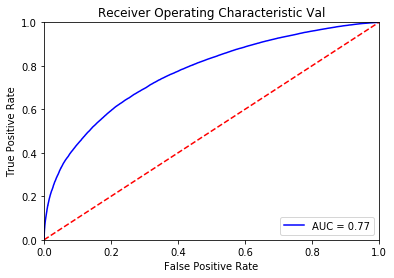

Real Probability


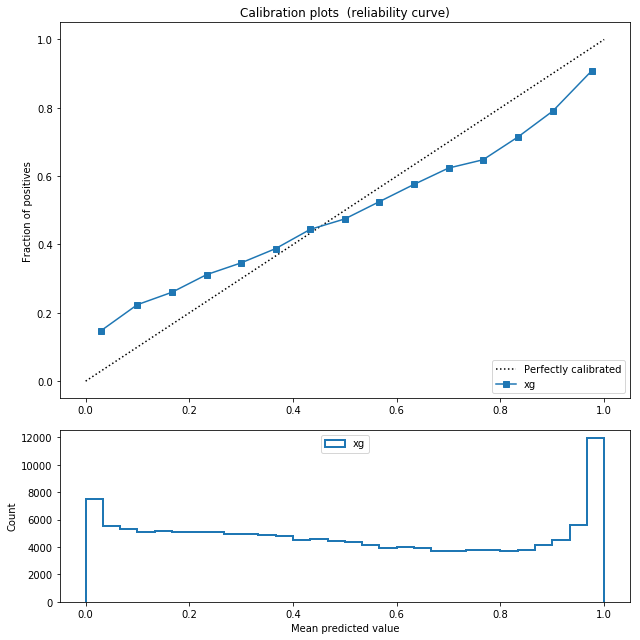

In [11]:
df_clean = df_bk.copy()

df_train = pipe.transform(df_clean)

df_train['HIGH_SCORE'] = list(df_clean['HIGH_SCORE'])

df_train, __ = train_test_split(df_train, test_size=0.2, random_state=666, stratify=df_devel['HIGH_SCORE'])

X, y = df_train.drop(columns=['HIGH_SCORE',],axis=1), df_train['HIGH_SCORE']
xg = xgb_pipe(X, y, 668, 0.2, minimize)

## Model persistance

In [12]:
pipe_file = './saves/'
joblib.dump(xg, '{}pipe_xgbN_270720.pkl'.format(pipe_file))

['./saves/pipeN_xgb_270720.pkl']

## Model evaluation

The trained model is saved and applied in the test set.

In [8]:
import sys
sys.path.append('./lambda_XGB/')
from test_pipe_funcs import pipeline_features

In [9]:
pipe_file = './saves/'
pipe = joblib.load('{}pipe_preprocN_280720.pkl'.format(pipe_file))
xg = joblib.load('{}pipe_xgbN_280720.pkl'.format(pipe_file))

In [10]:
df_test = pd.read_csv('./saberpro_2016-2019_test_v4.zip',sep=';')

df_bk_t = df_test.copy()
#df_test = df_bk_t.copy()

In [11]:
df_test = df_bk_t.copy()

df_test = pipe.transform(df_test)

#scaler_target = MaxAbsScaler()
#df_train['PUNT_GLOBAL_SCALED'] = scaler_target.fit_transform(df_clean[['PUNT_GLOBAL',]])
df_test['HIGH_SCORE'] = (df_bk_t['percentile'] > 50.00).astype(int)
df_test['PUNT_GLOBAL'] = list(df_bk_t['PUNT_GLOBAL'])

df_test.head()

,ESTU_INSE_INDIVIDUAL,TASA_HOMICIDIOS_4_LOG,AGE_APROX,ESTU_EXTERIOR_NO,ESTU_EXTERIOR_SI,ESTU_DEPTO_RESIDE_AMAZONAS,ESTU_DEPTO_RESIDE_ANTIOQUIA,ESTU_DEPTO_RESIDE_ARAUCA,ESTU_DEPTO_RESIDE_ATLANTICO,ESTU_DEPTO_RESIDE_BOGOTA,...,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SANTIAGO DE CALI,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SANTO TOMAS,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SERGIO ARBOLEDA,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SIMON BOLIVAR,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SURCOLOMBIANA,INST_NOMBRE_INSTITUCION_UNIVERSIDAD TECNOLOGICA DE PEREIRA,INST_NOMBRE_INSTITUCION_new,ESTU_NACIONALIDAD,HIGH_SCORE,PUNT_GLOBAL
0,0.860654,-1.018436,1.349859,0.053472,-0.053472,-0.016796,-0.369434,-0.050117,-0.24611,-0.639437,...,-0.096382,-0.135054,-0.073806,-0.098686,-0.077368,-0.086349,-0.606904,0.045565,1,148.0
1,0.084709,-2.972744,-0.521524,0.053472,-0.053472,-0.016796,-0.369434,-0.050117,-0.24611,-0.639437,...,-0.096382,-0.135054,-0.073806,-0.098686,-0.077368,-0.086349,-0.606904,0.045565,1,159.0
2,-0.450065,-0.044463,-0.677473,0.053472,-0.053472,-0.016796,-0.369434,-0.050117,-0.24611,-0.639437,...,-0.096382,-0.135054,-0.073806,-0.098686,-0.077368,-0.086349,-0.606904,0.045565,1,166.0
3,-0.236717,0.851523,-0.209627,0.053472,-0.053472,-0.016796,-0.369434,-0.050117,-0.24611,-0.639437,...,-0.096382,-0.135054,-0.073806,-0.098686,-0.077368,-0.086349,-0.606904,0.045565,1,155.0
4,1.330317,-0.553075,-0.677473,0.053472,-0.053472,-0.016796,-0.369434,-0.050117,-0.24611,1.563876,...,-0.096382,-0.135054,-0.073806,-0.098686,-0.077368,-0.086349,1.647708,0.045565,1,146.0


In [12]:
pipe_types = ['pass_bin','pass_num','dummie','dummie_nan']
df_normalization = extract_normalization(pipe,df_test,pipe_types)
df_normalization

,ESTU_INSE_INDIVIDUAL,TASA_HOMICIDIOS_4_LOG,AGE_APROX,ESTU_EXTERIOR_NO,ESTU_EXTERIOR_SI,ESTU_DEPTO_RESIDE_AMAZONAS,ESTU_DEPTO_RESIDE_ANTIOQUIA,ESTU_DEPTO_RESIDE_ARAUCA,ESTU_DEPTO_RESIDE_ATLANTICO,ESTU_DEPTO_RESIDE_BOGOTA,...,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SANTIAGO DE CALI,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SANTO TOMAS,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SERGIO ARBOLEDA,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SIMON BOLIVAR,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SURCOLOMBIANA,INST_NOMBRE_INSTITUCION_UNIVERSIDAD TECNOLOGICA DE PEREIRA,INST_NOMBRE_INSTITUCION_new,ESTU_NACIONALIDAD,HIGH_SCORE,PUNT_GLOBAL
index,,,,,,,,,,,,,,,,,,,,,
std,10.3259,0.542541,6.41237,0.0533191,0.0533191,0.0167915,0.325068,0.0499909,0.232055,0.453862,...,0.0954946,0.132635,0.0734066,0.0977346,0.0769072,0.0857095,0.443535,0.0454709,NaN,NaN
mean,51.9429,3.09342,26.3442,0.997149,0.00285105,0.000282033,0.120091,0.00250537,0.0571111,0.290216,...,0.00920392,0.0179129,0.00541788,0.00964508,0.00595012,0.00740089,0.269183,0.997928,NaN,NaN


In [13]:
df_normalization.to_csv('./normal_pars_280720.csv',sep=';',index=False)

------------------------------------
ROC Curve Test:


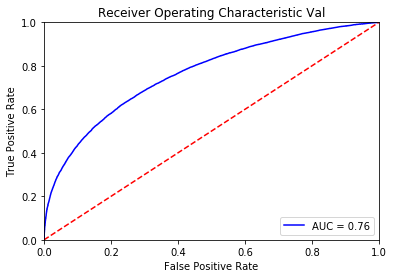

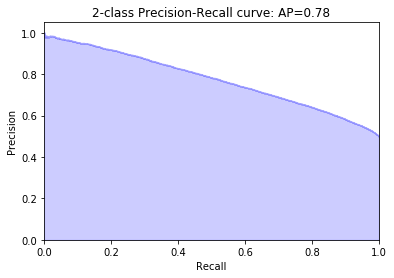

In [14]:
precision, recall, treshold = plot_roc_pr_curve(df_test.drop(columns=['HIGH_SCORE','PUNT_GLOBAL',],axis=1),
                                                df_test['HIGH_SCORE'],xg,False)

Brier Score
0.2032973887874087
       precision    recall  treshold        f1
16520   0.617228  0.842928   0.29505  0.712635
------------------------------------------------
Best Treshold: 0.2950497269630432
------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.48      0.59     26044
           1       0.62      0.84      0.71     25969

   micro avg       0.66      0.66      0.66     52013
   macro avg       0.69      0.66      0.65     52013
weighted avg       0.69      0.66      0.65     52013

------------------------------------------------
Confusion Matrix:


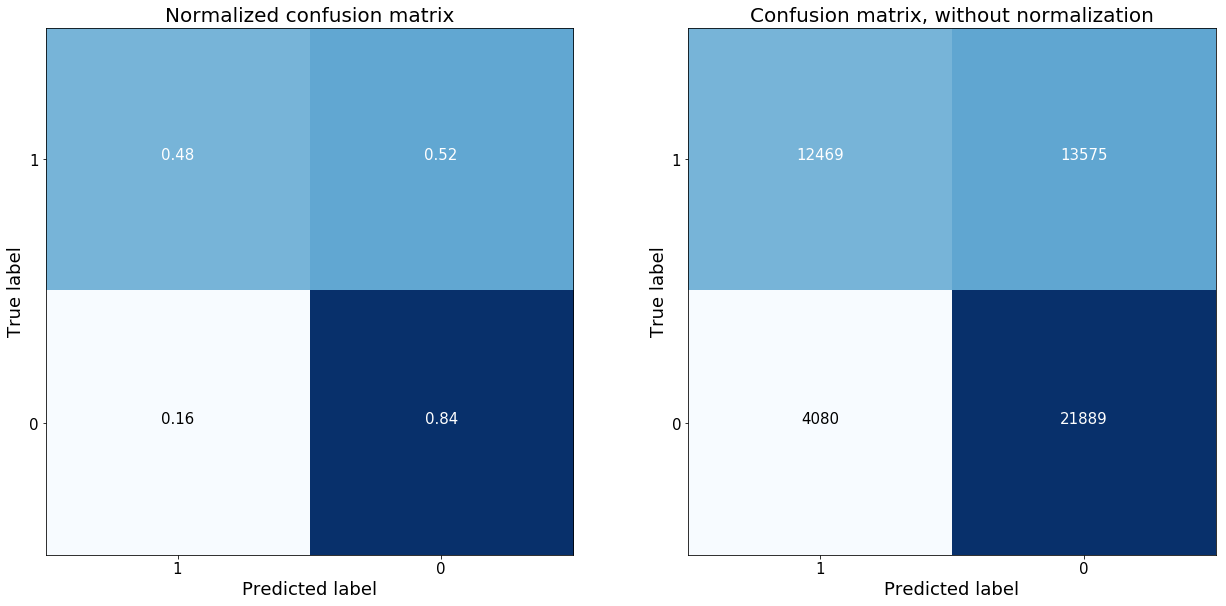

In [15]:
print('Brier Score')
print(metrics.brier_score_loss(df_test['HIGH_SCORE'],
                               xg.predict_proba(df_test.drop(columns=['HIGH_SCORE','PUNT_GLOBAL',],
                                                             axis=1))[:,1]))

treshold = np.append(treshold,1)
data = pd.DataFrame()
data["precision"] = precision
data["recall"] = recall
data["treshold"] = treshold
data["f1"] = 2*precision*recall/(precision+recall)
data = data.sort_values(by = ["f1"],ascending=False)
print(data.head(1))
corte = data["treshold"].iloc[0]
print('------------------------------------------------')
print("Best Treshold: {}".format(data["treshold"].iloc[0]))

result = (xg.predict_proba(df_test.drop(columns=['HIGH_SCORE','PUNT_GLOBAL',],
                                        axis=1)) > data["treshold"].iloc[0])[:,1].astype(int)

print('------------------------------------------------')

print(metrics.classification_report(df_test['HIGH_SCORE'], result))

print('------------------------------------------------')
print('Confusion Matrix:')

cnf_matrix = metrics.confusion_matrix(df_test['HIGH_SCORE'], result)
np.set_printoptions(precision=2)
class_names = df_test['HIGH_SCORE'].unique()

plt.subplots(figsize=(18, 16))
plt.subplot(2,2,1)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                           title='Normalized confusion matrix')
plt.subplot(2,2,2)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                           title='Confusion matrix, without normalization')
plt.show()

In [16]:
df_test['HIGH_SCORE_PREDICT'] = xg.predict(df_test.drop(columns=['HIGH_SCORE','PUNT_GLOBAL',],axis=1))
df_test['HIGH_SCORE_PROBA'] = xg.predict_proba(df_test.drop(columns=['HIGH_SCORE','PUNT_GLOBAL',
                                                                     'HIGH_SCORE_PREDICT',]
                                                            ,axis=1))[:,1]

df_test[['PUNT_GLOBAL','HIGH_SCORE','HIGH_SCORE_PREDICT','HIGH_SCORE_PROBA',]].head()

,PUNT_GLOBAL,HIGH_SCORE,HIGH_SCORE_PREDICT,HIGH_SCORE_PROBA
0,148.0,1,0,0.479419
1,159.0,1,1,0.666652
2,166.0,1,1,0.830862
3,155.0,1,0,0.168094
4,146.0,1,1,0.868451


We can use the probability of the model (probability of obtaining a high score) to group the test set into buckets (deciles), having the inferior buckets lower probabilities of high scores. For the given buckets (providen by the model) we will measure the real performance using the target variable and the obtained scores.

In [17]:
df_test['decil_score'] = pd.cut(df_test['HIGH_SCORE_PROBA'], bins=10)
df_test['decil_label'] = pd.cut(df_test['HIGH_SCORE_PROBA'], bins=10, labels=np.arange(10))

pd.concat([df_test.groupby(['decil_score','decil_label']).agg({'HIGH_SCORE_PREDICT':['count','sum'],}),
           df_test.groupby(['decil_score','decil_label'])['HIGH_SCORE_PREDICT'].sum()/
           df_test.groupby(['decil_score','decil_label'])['HIGH_SCORE_PREDICT'].count(),
           df_test.groupby(['decil_score','decil_label'])['HIGH_SCORE'].sum(),
           df_test.groupby(['decil_score','decil_label'])['HIGH_SCORE'].sum()/
           df_test.groupby(['decil_score','decil_label'])['HIGH_SCORE'].count(),
           df_test.groupby(['decil_score','decil_label'])['PUNT_GLOBAL'].mean(),],axis=1)

,,"(HIGH_SCORE_PREDICT, count)","(HIGH_SCORE_PREDICT, sum)",HIGH_SCORE_PREDICT,HIGH_SCORE,HIGH_SCORE,PUNT_GLOBAL
decil_score,decil_label,,,,,,
"(-0.000999, 0.1]",0,5368,0,0.0,896,0.166915,128.142697
"(0.1, 0.2]",1,5682,0,0.0,1497,0.263464,134.355509
"(0.2, 0.3]",2,5778,0,0.0,1793,0.310315,137.128937
"(0.3, 0.4]",3,5655,0,0.0,2220,0.392573,140.653935
"(0.4, 0.5]",4,5181,0,0.0,2359,0.455318,143.696391
"(0.5, 0.6]",5,4586,4586,1.0,2381,0.519189,146.319669
"(0.6, 0.7]",6,3981,3981,1.0,2337,0.587038,149.821402
"(0.7, 0.8]",7,3848,3848,1.0,2511,0.652547,152.944387
"(0.8, 0.9]",8,3954,3954,1.0,2895,0.732170,158.089530


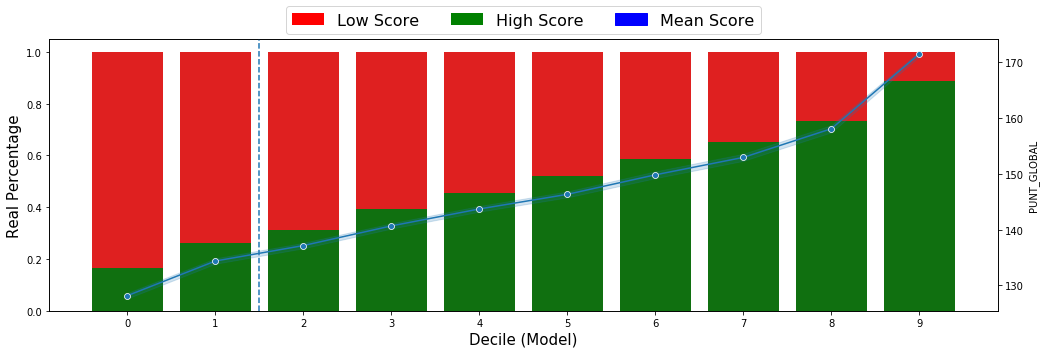

In [18]:
fig, axes = plt.subplots(figsize=(17, 5))
sns.barplot(x=df_test['decil_label'], y=df_test['HIGH_SCORE']+(1.0-df_test['HIGH_SCORE']), color="red")
high_plot = sns.barplot(x=df_test['decil_label'], y=df_test['HIGH_SCORE'], color="green", ci=None)

lowbar = plt.Rectangle((0,0),1,1,fc='red', edgecolor = 'none')
highbar = plt.Rectangle((0,0),1,1,fc='green',  edgecolor = 'none')
meanbar = plt.Circle((0, 0), 0.1, color='blue')
l = plt.legend([lowbar, highbar, meanbar], ['Low Score', 'High Score', 'Mean Score'], 
               loc='upper center', ncol = 3, bbox_to_anchor=(0.5, 1.15), prop={'size':16}, fancybox=True)

plt.twinx()
sns.lineplot(x=df_test['decil_label'], y=df_test['PUNT_GLOBAL'],marker='o',) #label='Mean Score'
#plt.gca().set_yticklabels([ ' {:.2f}%'.format( i*100) for i in plt.gca().get_yticks()])
plt.grid(False)

plt.axvline(x=1.5, linestyle='--')
high_plot.set_ylabel('Real Percentage', fontsize=15)
high_plot.set_xlabel('Decile (Model)', fontsize=15)
plt.show()

So, we can select the students grouped into the first two buckets (using a probability threshold of p<=0.2) as underperforming students. We can see that these two buckets have a large proportion of students who do poorly on the saber-pro test. Also, these groups presented the lowest average scores.

## Shapley summary plot
We will use the Shap model (http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) implemeted in python (https://github.com/slundberg/shap) to interpret the model and the variables driving the underperforming students to obtaining low scores.

In [19]:
df_test = df_bk_t.copy()

df_test = pipe.transform(df_test)

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xg.steps[0][1])
shap_values = explainer.shap_values(df_test)

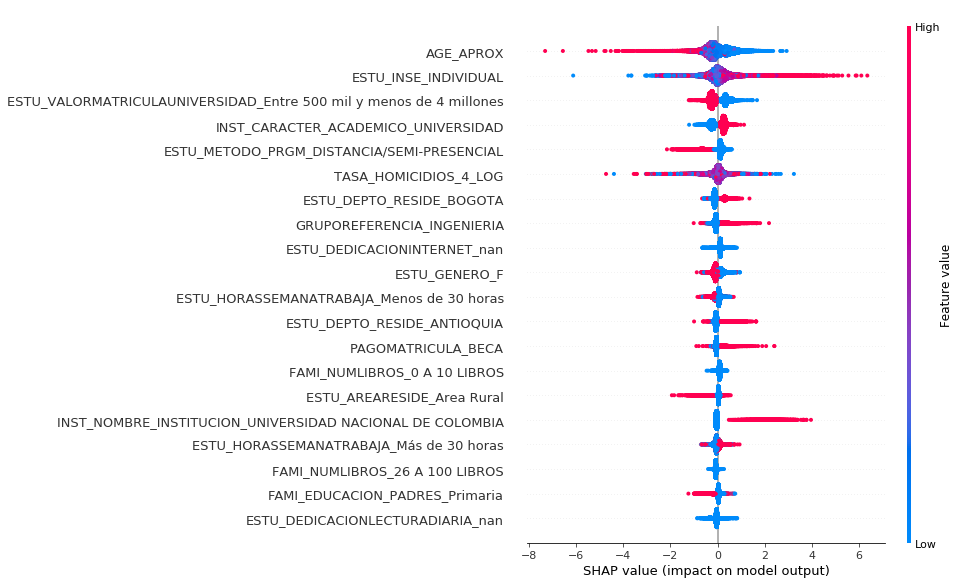

In [20]:
shap.summary_plot(np.array(shap_values), df_test)

In [21]:
#cols_shap = ['AGE_APROX','ESTU_INSE_INDIVIDUAL','INST_CARACTER_ACADEMICO_UNIVERSIDAD',
#             'ESTU_VALORMATRICULAUNIVERSIDAD_Entre 500 mil y menos de 4 millones','TASA_HOMICIDIOS_4_LOG',
#             'ESTU_METODO_PRGM_DISTANCIA/SEMI-PRESENCIAL','ESTU_GENERO_F']

df_shap = pd.DataFrame(shap_values,columns=df_test.columns,index=df_test.index)
df_shap.abs().sum().sort_values(ascending=False).head(10)

AGE_APROX                                                             20999.382812
ESTU_INSE_INDIVIDUAL                                                  20640.125000
ESTU_VALORMATRICULAUNIVERSIDAD_Entre 500 mil y menos de 4 millones    14746.397461
INST_CARACTER_ACADEMICO_UNIVERSIDAD                                   13842.156250
ESTU_METODO_PRGM_DISTANCIA/SEMI-PRESENCIAL                            13049.571289
TASA_HOMICIDIOS_4_LOG                                                 10395.170898
ESTU_DEPTO_RESIDE_BOGOTA                                               9495.162109
GRUPOREFERENCIA_INGENIERIA                                             6861.778809
ESTU_DEDICACIONINTERNET_nan                                            6589.149902
ESTU_GENERO_F                                                          6500.283203
dtype: float32

## Saving Shapley values

In [22]:
#np.save('./shapley_values.npy', shap_values)

## Shapley matrix

In [23]:
probs_pred = xg.predict_proba(df_test)[:,1]

In [24]:
#np.save('./probs_pred_280720.npy', probs_pred)

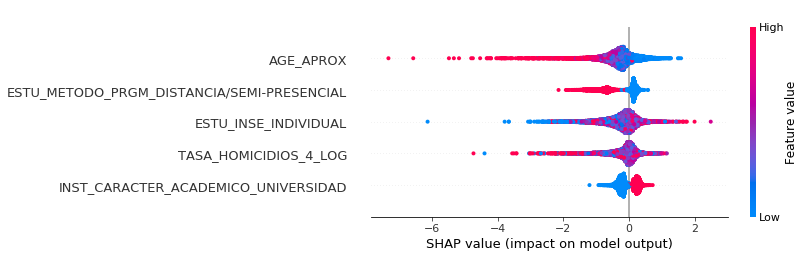

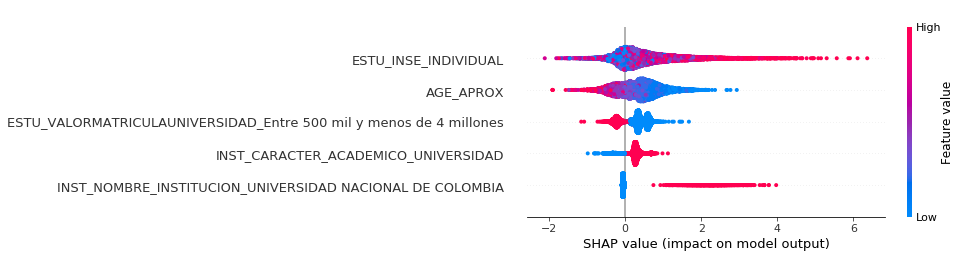

In [25]:
filter_low = probs_pred<=0.2
shap.summary_plot(np.array(df_shap[filter_low]), df_test[filter_low], max_display=5)
plt.show()
filter_high = probs_pred>0.8
shap.summary_plot(np.array(df_shap[filter_high]), df_test[filter_high], max_display=5)

In [44]:
df_test = df_bk_t.copy()
df_test = pipe.transform(df_test)

for i, col in enumerate(df_test.columns):
    df_test[col] = (df_test[col]*df_normalization.loc['std',col])+df_normalization.loc['mean',col]
df_test.head()

,ESTU_INSE_INDIVIDUAL,TASA_HOMICIDIOS_4_LOG,AGE_APROX,ESTU_EXTERIOR_NO,ESTU_EXTERIOR_SI,ESTU_DEPTO_RESIDE_AMAZONAS,ESTU_DEPTO_RESIDE_ANTIOQUIA,ESTU_DEPTO_RESIDE_ARAUCA,ESTU_DEPTO_RESIDE_ATLANTICO,ESTU_DEPTO_RESIDE_BOGOTA,...,INST_NOMBRE_INSTITUCION_UNIVERSIDAD PONTIFICIA BOLIVARIANA,INST_NOMBRE_INSTITUCION_UNIVERSIDAD POPULAR DEL CESAR,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SANTIAGO DE CALI,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SANTO TOMAS,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SERGIO ARBOLEDA,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SIMON BOLIVAR,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SURCOLOMBIANA,INST_NOMBRE_INSTITUCION_UNIVERSIDAD TECNOLOGICA DE PEREIRA,INST_NOMBRE_INSTITUCION_new,ESTU_NACIONALIDAD
0,60.829873,2.540876,35.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.673617e-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,52.817576,1.480584,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.673617e-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,47.295579,3.069297,22.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.673617e-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,49.498580,3.555406,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.673617e-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,65.679550,2.793354,22.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,8.673617e-19,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


### Relevant variables study

From the relevant variables, we check the distribution of this variables in the different groups

In [45]:
#df_test['PUNT_GLOBAL'] = list(df_bk_t['PUNT_GLOBAL'])

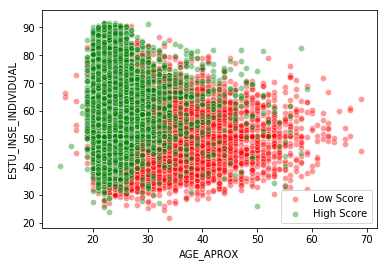

In [46]:
sns.scatterplot(x='AGE_APROX', y='ESTU_INSE_INDIVIDUAL', data=df_test[filter_low], 
                color='red', alpha=0.4, label='Low Score')
sns.scatterplot(x='AGE_APROX', y='ESTU_INSE_INDIVIDUAL', data=df_test[filter_high], 
                color='green', alpha=0.4, label='High Score')

In [47]:
df_test['group'] = 'mid'
df_test.loc[filter_low,'group'] = 'low'
df_test.loc[filter_high,'group'] = 'high'

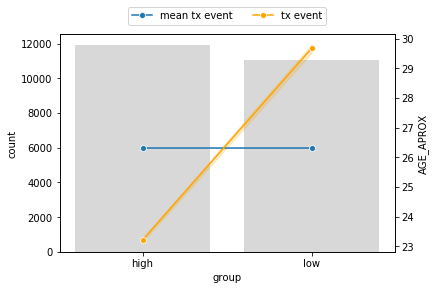

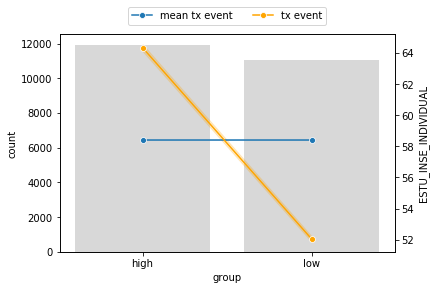

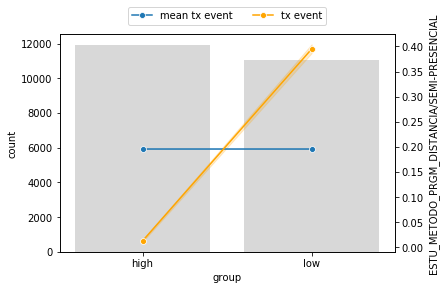

In [48]:
filter_comp = df_test['group'] != 'mid'
df_comp = df_test[filter_comp]

def plot_comp(df, col_x, col_y):
    sns.countplot(col_x, data=df, color='gray', alpha = 0.3)
    plt.twinx()
    sns.lineplot(x=df[col_x], y=df[col_y].mean(),marker='o', label='mean tx event')
    sns.lineplot(x=df[col_x], y=df[col_y],marker='o', color='orange', label='tx event')
    plt.legend(loc= 9, ncol=2, bbox_to_anchor=(0.5, 1.15))
    plt.show()

plot_comp(df_comp, 'group', 'AGE_APROX')
plot_comp(df_comp, 'group', 'ESTU_INSE_INDIVIDUAL')
plot_comp(df_comp, 'group', 'ESTU_METODO_PRGM_DISTANCIA/SEMI-PRESENCIAL')

In [49]:
categories=['AGE_APROX','ESTU_METODO_PRGM_DISTANCIA/SEMI-PRESENCIAL','ESTU_INSE_INDIVIDUAL',
            'INST_CARACTER_ACADEMICO_UNIVERSIDAD','TASA_HOMICIDIOS_4_LOG']

df_group = df_test.groupby('group')[categories].mean()
df_group['ESTU_METODO_PRGM_DISTANCIA/SEMI-PRESENCIAL'] = df_group['ESTU_METODO_PRGM_DISTANCIA/SEMI-PRESENCIAL']*30
df_group['ESTU_INSE_INDIVIDUAL'] = df_group['ESTU_INSE_INDIVIDUAL']/2.5
df_group['INST_CARACTER_ACADEMICO_UNIVERSIDAD'] = df_group['INST_CARACTER_ACADEMICO_UNIVERSIDAD']*30
df_group['TASA_HOMICIDIOS_4_LOG'] = df_group['TASA_HOMICIDIOS_4_LOG']*8
df_group

,AGE_APROX,ESTU_METODO_PRGM_DISTANCIA/SEMI-PRESENCIAL,ESTU_INSE_INDIVIDUAL,INST_CARACTER_ACADEMICO_UNIVERSIDAD,TASA_HOMICIDIOS_4_LOG
group,,,,,
high,23.211748,0.379588,25.736895,27.619407,23.339232
low,29.675294,11.845249,20.814981,12.743891,24.892698
mid,26.347342,4.254711,22.530764,16.601330,23.922619


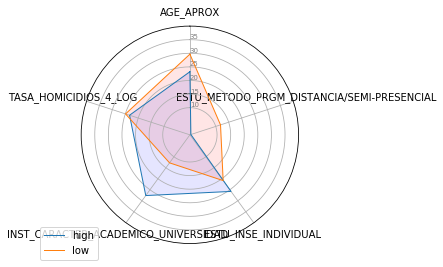

In [50]:
# Libraries
from math import pi

# ------- PART 1: Create background
 
# number of variable
categories=['AGE_APROX','ESTU_METODO_PRGM_DISTANCIA/SEMI-PRESENCIAL','ESTU_INSE_INDIVIDUAL',
            'INST_CARACTER_ACADEMICO_UNIVERSIDAD','TASA_HOMICIDIOS_4_LOG']

N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
#plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
y_list = np.arange(10,40,5)
plt.yticks(y_list, y_list.astype(str), color="grey", size=7)
plt.ylim(0,40)

# ------- PART 2: Add plots

# Ind1
values=df_group.loc['high'].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="high")
ax.fill(angles, values, 'b', alpha=0.1)

# Ind2
values=df_group.loc['low'].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="low")
ax.fill(angles, values, 'r', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

# Shapley force plot (Low vs High)
We will use the force plot shapley to verify the driving variables that push the underperforming students to low scores. From the underperforming group, we will verify the top variables that drive the students into lower scores more frequently. Also, we will verify these driving variables by department. 

In [51]:
#probs_pred = xg.predict_proba(df_test)[:,1]

In [52]:
filter_low = probs_pred<=0.2
shap.force_plot(explainer.expected_value, shap_values[filter_low][110], 
                df_test.drop('group',axis=1)[filter_low].iloc[110])

In [53]:
filter_high = probs_pred>0.8
shap.force_plot(explainer.expected_value, shap_values[filter_high][120], 
                df_test.drop('group',axis=1)[filter_high].iloc[120])

In [54]:
lower_idx = shap_values[filter_low].argsort()[:,:5]#lower
higher_idx = shap_values[filter_low].argsort()[:,-5:]#higher

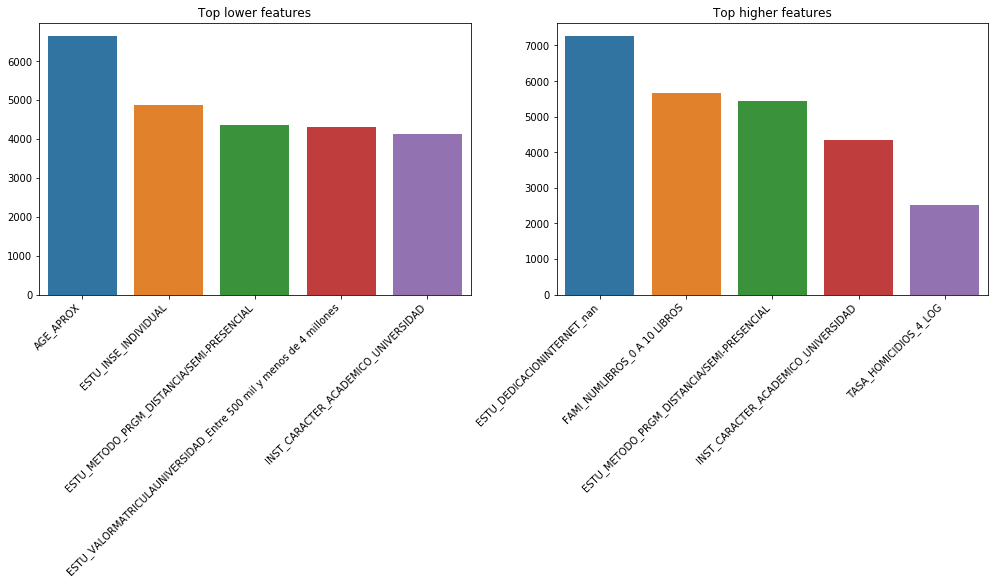

In [55]:
from collections import Counter

columns_df = df_test[filter_low].columns

lower_idx_ord = Counter(lower_idx.flatten())
lower_idx_ord = {columns_df[el[0]]: el[1] for el in lower_idx_ord.most_common()}
higher_idx_ord = Counter(higher_idx.flatten())
higher_idx_ord = {columns_df[el[0]]: el[1] for el in higher_idx_ord.most_common()}

fig, axes = plt.subplots(1,2,figsize=(17, 5))
c_plt = sns.barplot(list(lower_idx_ord.keys())[:5], list(lower_idx_ord.values())[:5],ax=axes[0])
c_plt.set_xticklabels(c_plt.get_xticklabels(), rotation=45, horizontalalignment='right',)
c_plt.set_title('Top lower features')
c_plt = sns.barplot(list(higher_idx_ord.keys())[:5], list(higher_idx_ord.values())[:5],ax=axes[1])
c_plt.set_xticklabels(c_plt.get_xticklabels(), rotation=45, horizontalalignment='right',)
c_plt.set_title('Top higher features')
plt.show()

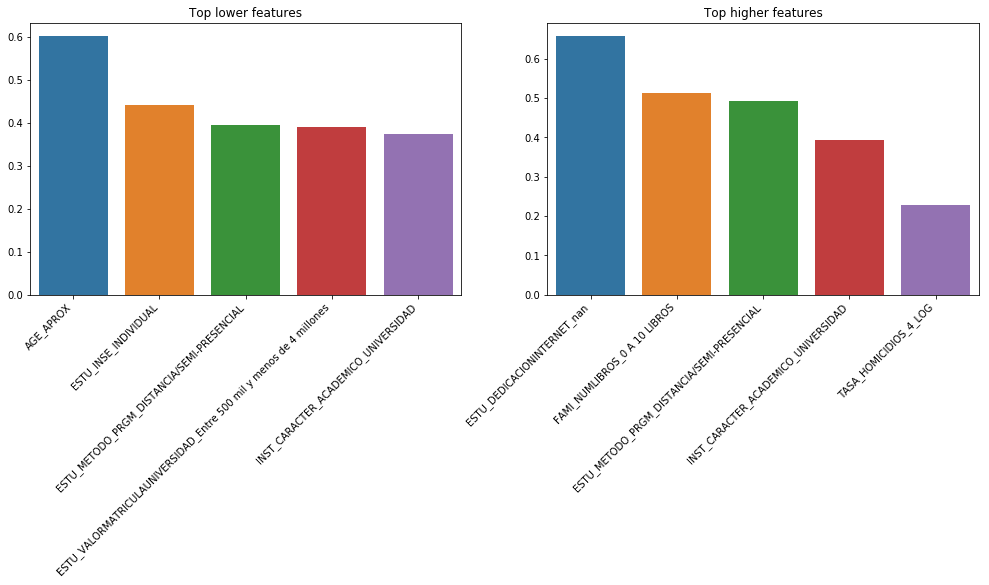

In [56]:
from collections import Counter

columns_df = df_test[filter_low].columns
size_low = df_test[filter_low].shape[0]

lower_idx_ord = Counter(lower_idx.flatten())
lower_idx_ord = {columns_df[el[0]]: el[1] for el in lower_idx_ord.most_common()}
higher_idx_ord = Counter(higher_idx.flatten())
higher_idx_ord = {columns_df[el[0]]: el[1] for el in higher_idx_ord.most_common()}

fig, axes = plt.subplots(1,2,figsize=(17, 5))
c_plt = sns.barplot(list(lower_idx_ord.keys())[:5], np.array(list(lower_idx_ord.values())[:5])/size_low,ax=axes[0])
c_plt.set_xticklabels(c_plt.get_xticklabels(), rotation=45, horizontalalignment='right',)
c_plt.set_title('Top lower features')
c_plt = sns.barplot(list(higher_idx_ord.keys())[:5], np.array(list(higher_idx_ord.values())[:5])/size_low,ax=axes[1])
c_plt.set_xticklabels(c_plt.get_xticklabels(), rotation=45, horizontalalignment='right',)
c_plt.set_title('Top higher features')
plt.show()

# Shapley force plot (By department)
We will compare three states with different test performance: Bogotá (highest performance), Vichada (regular performance), and Chocó (lowest performance).

In [57]:
df_test.loc[df_test.ESTU_DEPTO_RESIDE_CHOCO==1.0].group.value_counts()

low     218
mid      31
high      2
Name: group, dtype: int64

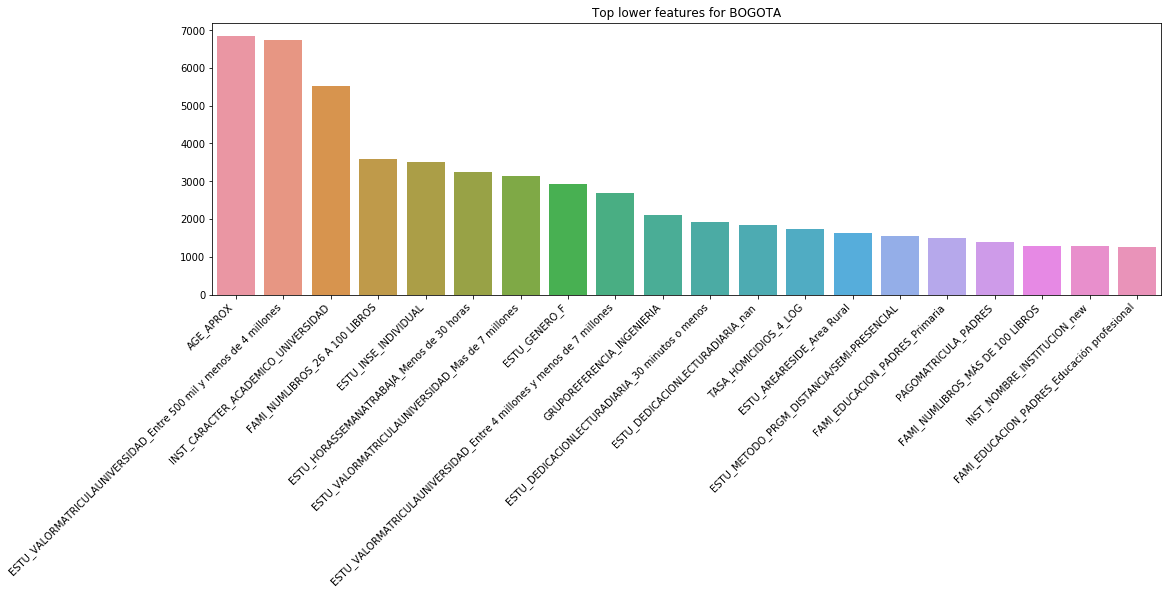

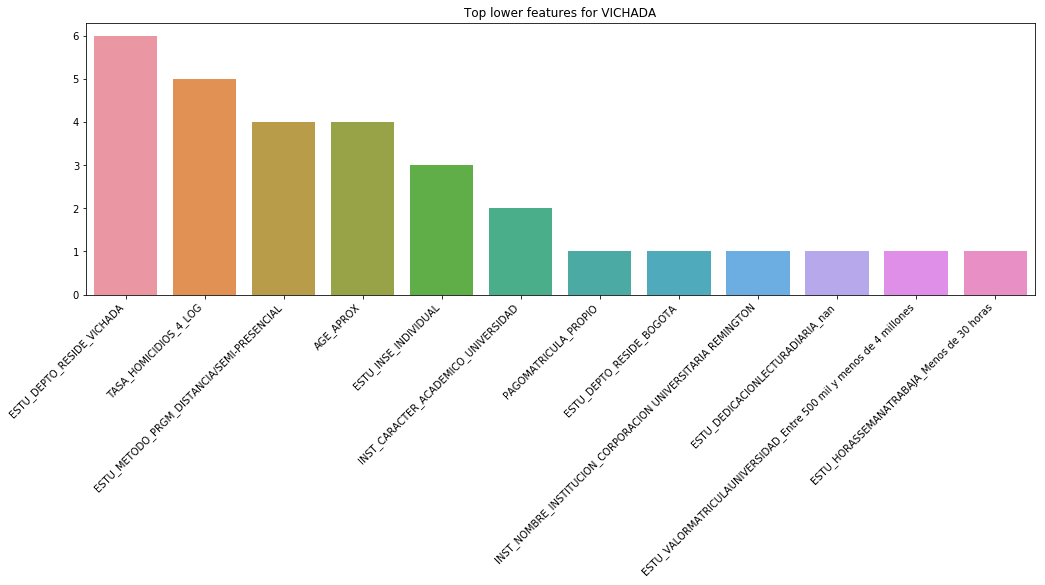

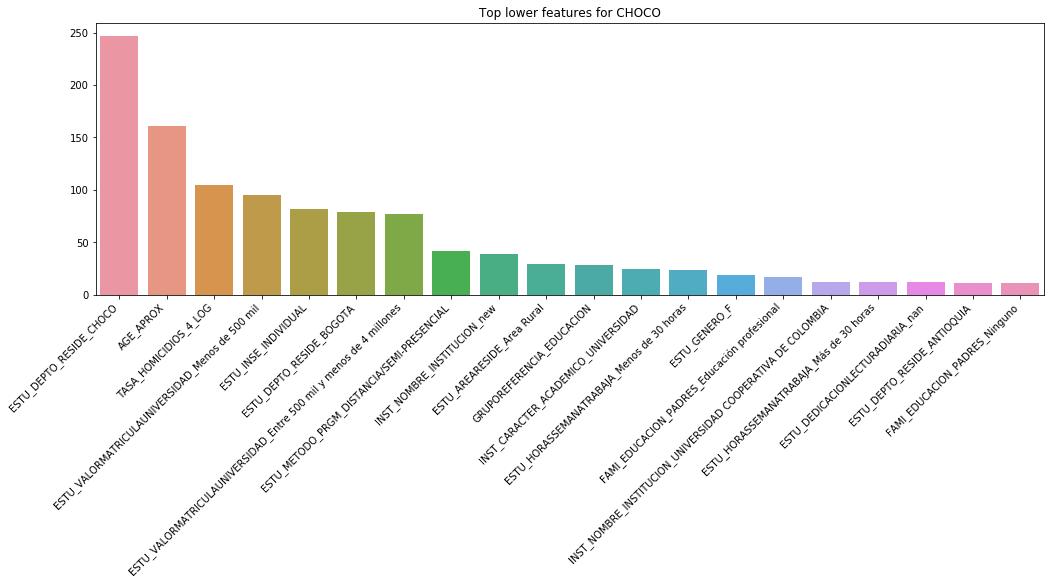

In [58]:
df_dept = df_test.drop('group',axis=1).copy()
df_dept['HIGH_SCORE_PROBA'] = xg.predict_proba(df_dept)[:,1]
df_dept['ESTU_DEPTO_RESIDE'] = list(df_bk_t['ESTU_DEPTO_RESIDE'])

departamentos = ['BOGOTA', 'VICHADA', 'CHOCO']

for departamento in departamentos:

    filter_dept = (df_dept['HIGH_SCORE_PROBA']<=0.2) & (df_dept['ESTU_DEPTO_RESIDE']==departamento)
    lower_idx = shap_values[filter_dept].argsort()[:,:5]#lower

    lower_idx_ord = Counter(lower_idx.flatten())
    lower_idx_ord = {columns_df[el[0]]: el[1] for el in lower_idx_ord.most_common()}

    fig, axes = plt.subplots(figsize=(17, 5))
    sns.barplot(list(lower_idx_ord.keys())[:20], list(lower_idx_ord.values())[:20])
    plt.xticks(rotation=45, horizontalalignment='right')
    plt.title('Top lower features for {}'.format(departamento))
    plt.show()

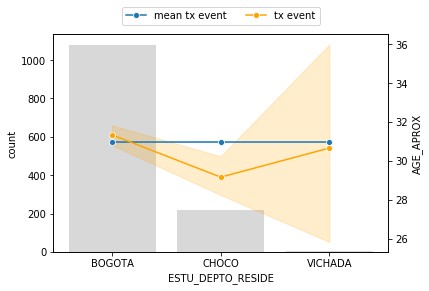

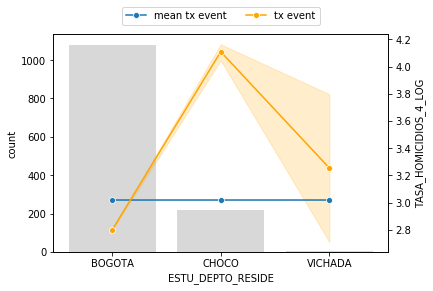

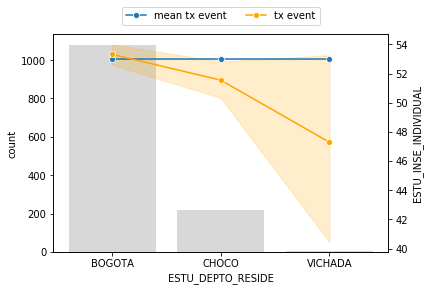

In [59]:
df_test['ESTU_DEPTO_RESIDE'] = list(df_bk_t['ESTU_DEPTO_RESIDE'])
filter_comp = (df_test['group'] == 'low') & (df_test['ESTU_DEPTO_RESIDE'].isin(departamentos))
df_comp = df_test[filter_comp]

def plot_comp(df, col_x, col_y):
    sns.countplot(col_x, data=df, color='gray', alpha = 0.3)
    plt.twinx()
    sns.lineplot(x=df[col_x], y=df[col_y].mean(),marker='o', label='mean tx event')
    sns.lineplot(x=df[col_x], y=df[col_y],marker='o', color='orange', label='tx event')
    plt.legend(loc= 9, ncol=2, bbox_to_anchor=(0.5, 1.15))
    plt.show()

plot_comp(df_comp, 'ESTU_DEPTO_RESIDE', 'AGE_APROX')
plot_comp(df_comp, 'ESTU_DEPTO_RESIDE', 'TASA_HOMICIDIOS_4_LOG')
plot_comp(df_comp, 'ESTU_DEPTO_RESIDE', 'ESTU_INSE_INDIVIDUAL')

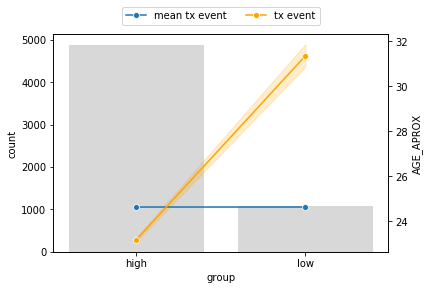

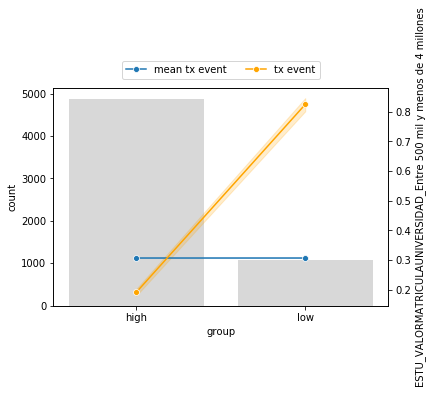

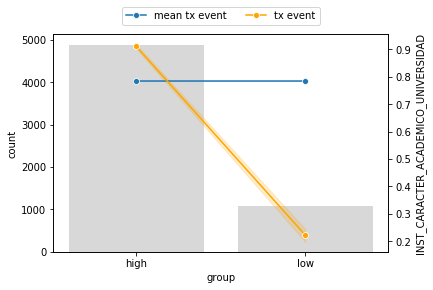

In [60]:
filter_comp = (df_test['ESTU_DEPTO_RESIDE']=='BOGOTA') & (df_test['group'] != 'mid')
df_comp = df_test[filter_comp]

def plot_comp(df, col_x, col_y):
    sns.countplot(col_x, data=df, color='gray', alpha = 0.3)
    plt.twinx()
    sns.lineplot(x=df[col_x], y=df[col_y].mean(),marker='o', label='mean tx event')
    sns.lineplot(x=df[col_x], y=df[col_y],marker='o', color='orange', label='tx event')
    plt.legend(loc= 9, ncol=2, bbox_to_anchor=(0.5, 1.15))
    plt.show()
    
plot_comp(df_comp, 'group', 'AGE_APROX')
plot_comp(df_comp, 'group', 'ESTU_VALORMATRICULAUNIVERSIDAD_Entre 500 mil y menos de 4 millones')
plot_comp(df_comp, 'group', 'INST_CARACTER_ACADEMICO_UNIVERSIDAD')

# Conclusions
* The model got 76% of AUC in the validation set, and 75% in the test set, that is a good measure in terms of a real dataset. However, the number of false positives remains high (specificity = 51%). Still, the model was useful to detect low-score students.
* Most relevant variables are:
    * The lower the socio-economical index (INSE), the higher the chance of doing poorly on the test.
    * The higher the age, the higher the chance of doing poorly on the test.
    * Institutions that are not formally constituted as universities are associated with worse scores.
    * Programs costing between 500.000 and 4 COP are associated with worse scores.
    * It is not well defined, but in general, the higher the homicide rate during the last 4 years, the higher the chance of doing poorly on the test. There are some groups that do not follow this trend due to interaction with other variables.
* Using the model, we can predict underperforming students (using a threshold probability of 0.2). These students have a large percentage who really will do poorly on the saber-pro test (approximately 75%).
* In the underperforming students group, appear a new variable that drives students to low scores: distance and semi-presential programs.
* By comparing the top variables that hurt underperforming students in Bogotá, Vichada and Chocó, we found common variables, some already identified. However, some are surprising:
    * Bogotá is affected by rural/urban living: 30% of underperforming students live in rural area, while in the group of high scores only 4% live in rural area.
    * In Chocó violence index becomes very relevant. Also, in Chocó, students who pay less than 500.000 COP have higher chances of low scores. It can be related with low income.